# Data Preprocessing of MRI Brain images for detection of brain cancer (`dataset_1`)

Three approaches were taken to preprocess the brain MRI dataset:

<ins>Approach 1: Preprocess First</ins>
1. Preprocess dataset
2. Export preprocessed images into a new folder
3. Utilise new preprocessed images to build the model

<ins>Approach 2: Integrated Preprocessing</ins>
1. Add preprocessing steps directly as layers of the model
2. Build the model on top of these preprocessing layers

<ins>Approach 3: Hybrid Approach</ins>
1. Preprocess dataset and export the preprocessed images into a new folder
2. Add additional preprocessing steps directly as layers of the model
3. Build the model on top of preprocessing layers, utilising the exported images

`Approach 1` was utilised in early stages of the project to visualise preprocessing and data augmentation operations performed on the dataset. This approach was used to solidfy the preprocessing pipeline required.

Subsequently, `Approach 2` was utilised to directly integrate the preprocessing operations identified from experiments using `Approach 1` into the models. `Approach 2` is preferred as it removes the need for a separate preprocessing step prior to building the model.

Whilst available, `Approach 3` was not utilised during the project, as there were no preprocessing operations found in `Approach 1` that could not be directly integrated into the models. However, `Approach 3` was always kept open as a viable option, should there be a need for such ad-hoc operations prior to building the model.

In [2]:
# Imports
from config import *
import os, cv2, random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Exploratory Data Analysis

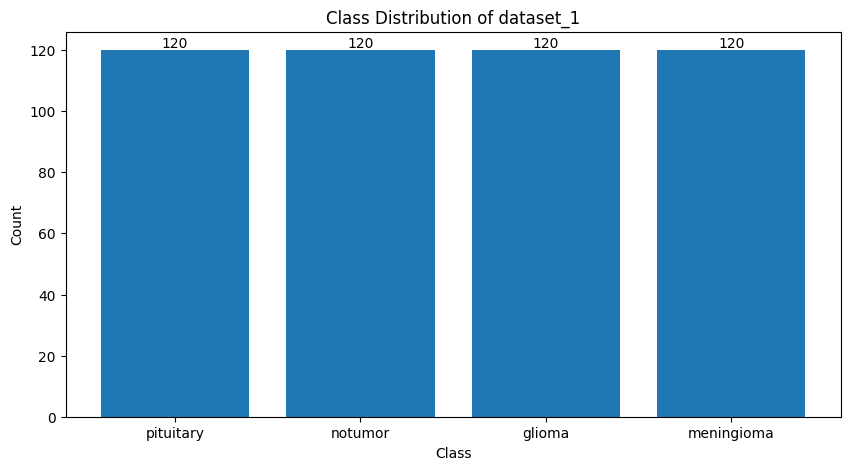

In [3]:
# Get class distribution of dataset
class_counts = Counter()
for root, dirs, files in os.walk(DATASET_FOLDER):
    for dir_name in dirs:
        class_path = os.path.join(root, dir_name)
        class_counts[dir_name] = len(os.listdir(class_path))
    break

plt.figure(figsize=(10, 5))
bar_chart = plt.bar(class_counts.keys(), class_counts.values())
for bar in bar_chart:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, str(height), ha='center', va='bottom')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title("Class Distribution of dataset_1")
plt.show()

## Data Augmentation
To enable the models to learn complex relationships and features, data augmentation was introduced to artificially increase the relatively small dataset's size by applying modifications on existing images, such as rotations and shifts. In doing so, new variation and noise are introduced to the models, enhancing their robustness and generalisation abilities, which in turn also helps in mitigating overfitting.

Data augmentation techniques employed include:
- Rotation: Rotating the image by a random angle.
- Horizontal and Vertical Flips: Flipping the image horizontally or vertically.
- Translation: Shifting the image horizontally or vertically.
- Zoom: Zooming into or out of the image.
- Shear: Shearing the image.
- Brightness and Contrast: Adjusting the brightness and contrast of the image.
- Noise Injection: Adding random noise to the image.

## Approach 1: Preprocess First
This approach was utilised to better visualise data preprocessing operations and solidify the data preprocessing pipeline required, prior to model building.

In [ ]:
# Function to perform augmentation and save images
def augment_and_save_image(image, target_dir, file_name_prefix, export=False, verbose=False):
    # Define image augmentation operations (EXPERIMENT WITH PARAMETERS)
    # datagen = ImageDataGenerator(
    #     rotation_range=15,             
    #     width_shift_range=0.1,         
    #     height_shift_range=0.1,
    #     brightness_range=[0.8, 1.2],   
    #     zoom_range=0.2,                
    #     shear_range=0.1,
    #     horizontal_flip = True,
    #     vertical_flip = False, # Avoid vertical_flip for brain MRIs
    #     fill_mode='nearest'
    # )
    
    # Define image augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range = 10,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'nearest'
    )
    
    # Reshape image to fit the expected input shape for ImageDataGenerator
    image = np.expand_dims(image, axis=0)
    
    # Generate augmented images
    augmented_images = datagen.flow(image, batch_size=1)
    
    # Save augmented images, if required
    if(export):
        for i, batch in enumerate(augmented_images):
            augmented_image = batch[0].astype(np.uint8)
            file_name = f"{file_name_prefix}_aug_{i}.jpg"
            target_path = os.path.join(target_dir, file_name)
            cv2.imwrite(target_path, augmented_image)
            
            # Regulate total no of generated augmented images
            if (i + 1) >= AUGMENT_COUNT:
                break

    # Display augmentations, if required
    if(verbose):
        # Save augmented images for visualisations
        list_augmented_images = []
        for i, batch in enumerate(augmented_images):
            # Convert images from BGR to RGB for matplotlib
            augmented_image = batch[0].astype(np.uint8)
            augmented_rgb = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)
            list_augmented_images.append(augmented_rgb)
            
            # Regulate total no of generated augmented images
            if (i + 1) >= AUGMENT_COUNT:
                break
        
        # Convert original image from BGR to RGB for matplotlib
        original_rgb = cv2.cvtColor(image[0], cv2.COLOR_BGR2RGB)
        
        # Display original and augmented images side by side
        plt.figure(figsize=(16, 6))
        
        # Original image
        plt.subplot(1, AUGMENT_COUNT + 1, 1)
        plt.imshow(original_rgb)
        plt.title('Original')
        plt.axis('off')
        
        # Augmented images
        for i in range(len(list_augmented_images)):
            plt.subplot(1, AUGMENT_COUNT + 1, i + 2)
            plt.imshow(list_augmented_images[i])
            plt.title(f'Augmented {i + 1}')
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()

In [ ]:
# Iterate through each subdirectory in the dataset
for subdir in os.listdir(DATASET_FOLDER):
    subdir_path = os.path.join(DATASET_FOLDER, subdir)
    print(subdir)
    if os.path.isdir(subdir_path):
        # Create corresponding subdirectory in target_dir
        target_subdir = os.path.join(NEW_DATASET_FOLDER, subdir)
        os.makedirs(target_subdir, exist_ok=True)
        
        # Visualisation counter
        counter = 0
        
        # Iterate through images in the subdirectory
        for file_name in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, file_name)
            if os.path.isfile(file_path) and file_name.endswith(".jpg"):
                # Read the image
                image = cv2.imread(file_path)
                
                # Perform data augmentation and save augmented images
                augment_and_save_image(image, target_subdir, os.path.splitext(file_name)[0], export=True, verbose=(counter < VISUALISE_COUNT))
                counter += 1